## Setup

In [1]:
from OPMD_acq.testbench_funcs import OPMD_TestBench, pm_modes
from experiment.experiment import tb 

/Users/mingyu/Desktop/OPMD_acq/OPMD_acq/testbench_funcs.py:101: UserWarning: no Archon connected to server, CCD functionality will be disabled...
  warn("no Archon connected to server, CCD functionality will be disabled...")


In [2]:
from time import sleep
import numpy as np
import pickle as pkl
import matplotlib.pyplot as plt
from pylab import rcParams
rcParams['figure.figsize'] = 12, 8

### Slow Source

In [3]:
# tb.start_lamp()
# tb.wavelength = 600 
# print(tb.wavelength)
# tb.get_lamp_current()
# tb.set_lamp_current(10.0)
# with tb.lamp_power_context(stoponsuccess=True) as session: 
#     pass 

In [4]:
# tb.stop_lamp()
tb.get_lamp_current()

10.0

### Power Meter

In [5]:
# tb.setup_photodiode(pm_modes.SINGLESHOT_MANUAL, 1)
# tb.photodiode_units = 'A'
# print(tb.photodiode_units)
# tb.measure_photodiode(1)
# tb.measure_light_current_instantaneous(1)
# tb.get_photodiode_responsivity(1)

### Spectrometer

In [6]:
# tb.read_spectrum(100)

### Parameter

In [7]:
wls = [460, 480, 500, 520, 540, 560, 580, 600, 620, 640, 660, 680, 700]
exposure = 300
trials = 400

## 1. Powermeter

In [1]:
from calibration.powermeter import run_powermeter
wls = [500, 520]
trials = 400
pause = 35
run_powermeter(wls, trials, pause)

/Users/mingyu/Desktop/OPMD_acq/OPMD_acq/testbench_funcs.py:101: UserWarning: no Archon connected to server, CCD functionality will be disabled...
  warn("no Archon connected to server, CCD functionality will be disabled...")


Setting the wavelength of the slow source to: 500.00
2020-02-19 01:18:49.438243 Working on trial 0
2020-02-19 01:19:24.630812 Working on trial 1
2020-02-19 01:19:59.851018 Working on trial 2
2020-02-19 01:20:36.730918 Working on trial 3
2020-02-19 01:21:11.921289 Working on trial 4
2020-02-19 01:21:47.116524 Working on trial 5
2020-02-19 01:22:29.315305 Working on trial 6
2020-02-19 01:23:27.247884 Working on trial 7
2020-02-19 01:24:02.430417 Working on trial 8
2020-02-19 01:24:37.628978 Working on trial 9
2020-02-19 01:25:12.848737 Working on trial 10
2020-02-19 01:25:48.037986 Working on trial 11
2020-02-19 01:26:23.257263 Working on trial 12
2020-02-19 01:27:00.140241 Working on trial 13
2020-02-19 01:27:35.382773 Working on trial 14
2020-02-19 01:28:10.591710 Working on trial 15
2020-02-19 01:28:45.818604 Working on trial 16
2020-02-19 01:29:21.099916 Working on trial 17
2020-02-19 01:29:56.469679 Working on trial 18
2020-02-19 01:30:31.692917 Working on trial 19
2020-02-19 01:31:

2020-02-19 03:03:48.169122 Working on trial 172
2020-02-19 03:04:23.371285 Working on trial 173
2020-02-19 03:04:58.593432 Working on trial 174
2020-02-19 03:05:35.617945 Working on trial 175
2020-02-19 03:06:12.542396 Working on trial 176
2020-02-19 03:06:47.878757 Working on trial 177
2020-02-19 03:07:23.085285 Working on trial 178
2020-02-19 03:07:58.309386 Working on trial 179
2020-02-19 03:08:33.528425 Working on trial 180
2020-02-19 03:09:08.880342 Working on trial 181
2020-02-19 03:09:44.105007 Working on trial 182
2020-02-19 03:10:19.288521 Working on trial 183
2020-02-19 03:10:54.467045 Working on trial 184
2020-02-19 03:11:29.671764 Working on trial 185
2020-02-19 03:12:04.896062 Working on trial 186
2020-02-19 03:12:40.100953 Working on trial 187
2020-02-19 03:13:15.326959 Working on trial 188
2020-02-19 03:13:50.534021 Working on trial 189
2020-02-19 03:14:25.762151 Working on trial 190
2020-02-19 03:15:00.968097 Working on trial 191
2020-02-19 03:15:36.164458 Working on tr

2020-02-19 04:46:41.904196 Working on trial 343
2020-02-19 04:47:17.108279 Working on trial 344
2020-02-19 04:47:52.307150 Working on trial 345
2020-02-19 04:48:27.537624 Working on trial 346
2020-02-19 04:49:02.765902 Working on trial 347
2020-02-19 04:49:37.973625 Working on trial 348
2020-02-19 04:50:13.178893 Working on trial 349
2020-02-19 04:50:48.360636 Working on trial 350
2020-02-19 04:51:23.554748 Working on trial 351
2020-02-19 04:51:58.761686 Working on trial 352
2020-02-19 04:52:33.988975 Working on trial 353
2020-02-19 04:53:09.190862 Working on trial 354
2020-02-19 04:53:44.387609 Working on trial 355
2020-02-19 04:54:19.706585 Working on trial 356
2020-02-19 04:54:54.921984 Working on trial 357
2020-02-19 04:56:20.590610 Working on trial 358
2020-02-19 04:56:57.736618 Working on trial 359
2020-02-19 04:57:32.953858 Working on trial 360
2020-02-19 04:58:29.965886 Working on trial 361
2020-02-19 04:59:05.180381 Working on trial 362
2020-02-19 04:59:40.404453 Working on tr

2020-02-19 06:31:22.715693 Working on trial 115
2020-02-19 06:31:59.944723 Working on trial 116
2020-02-19 06:32:35.165835 Working on trial 117
2020-02-19 06:33:59.870458 Working on trial 118
2020-02-19 06:34:35.069849 Working on trial 119
2020-02-19 06:35:10.294440 Working on trial 120
2020-02-19 06:35:54.364481 Working on trial 121
2020-02-19 06:36:29.583517 Working on trial 122
2020-02-19 06:37:04.808187 Working on trial 123
2020-02-19 06:37:40.024068 Working on trial 124
2020-02-19 06:38:15.226953 Working on trial 125
2020-02-19 06:38:50.445396 Working on trial 126
2020-02-19 06:39:25.658691 Working on trial 127
2020-02-19 06:40:00.857012 Working on trial 128
2020-02-19 06:40:36.055429 Working on trial 129
2020-02-19 06:41:11.275110 Working on trial 130
2020-02-19 06:41:46.521036 Working on trial 131
2020-02-19 06:42:21.713310 Working on trial 132
2020-02-19 06:42:56.908005 Working on trial 133
2020-02-19 06:43:32.116954 Working on trial 134
2020-02-19 06:44:07.304184 Working on tr

2020-02-19 08:12:44.078377 Working on trial 286
2020-02-19 08:13:19.282496 Working on trial 287
2020-02-19 08:13:54.470116 Working on trial 288
2020-02-19 08:14:29.675249 Working on trial 289
2020-02-19 08:15:04.898640 Working on trial 290
2020-02-19 08:15:40.123721 Working on trial 291
2020-02-19 08:16:15.350080 Working on trial 292
2020-02-19 08:16:50.553520 Working on trial 293
2020-02-19 08:17:25.772538 Working on trial 294
2020-02-19 08:18:00.986427 Working on trial 295
2020-02-19 08:18:36.190090 Working on trial 296
2020-02-19 08:19:11.369093 Working on trial 297
2020-02-19 08:19:46.570940 Working on trial 298
2020-02-19 08:20:21.773343 Working on trial 299
2020-02-19 08:20:56.965564 Working on trial 300
2020-02-19 08:21:32.189185 Working on trial 301
2020-02-19 08:22:07.393580 Working on trial 302
2020-02-19 08:22:42.594840 Working on trial 303
2020-02-19 08:23:17.819214 Working on trial 304
2020-02-19 08:23:53.045567 Working on trial 305
2020-02-19 08:24:28.269968 Working on tr

## 2. Spectrometer

In [1]:
from calibration.spectrometer import run_spectrometer
wls = [460, 480]
trials = 10
pause = 0
exposure = 300

run_spectrometer(wls, trials, pause, exposure)

/Users/mingyu/Desktop/OPMD_acq/OPMD_acq/testbench_funcs.py:101: UserWarning: no Archon connected to server, CCD functionality will be disabled...
  warn("no Archon connected to server, CCD functionality will be disabled...")


Setting the wavelength of the slow source to: 460.00
2020-02-19 01:15:15.918859 Working on trial 0
2020-02-19 01:15:16.474927 Working on trial 1
2020-02-19 01:15:17.095944 Working on trial 2
2020-02-19 01:15:17.710346 Working on trial 3
2020-02-19 01:15:18.326139 Working on trial 4
2020-02-19 01:15:18.939047 Working on trial 5
2020-02-19 01:15:19.555850 Working on trial 6
2020-02-19 01:15:20.171018 Working on trial 7
2020-02-19 01:15:20.800694 Working on trial 8
2020-02-19 01:15:21.490244 Working on trial 9
Setting the wavelength of the slow source to: 480.00
2020-02-19 01:15:34.546356 Working on trial 0
2020-02-19 01:15:35.368687 Working on trial 1
2020-02-19 01:15:36.160290 Working on trial 2
2020-02-19 01:15:36.991591 Working on trial 3
2020-02-19 01:15:37.820583 Working on trial 4
2020-02-19 01:15:38.633977 Working on trial 5
2020-02-19 01:15:39.434528 Working on trial 6
2020-02-19 01:15:40.270076 Working on trial 7
2020-02-19 01:15:41.080515 Working on trial 8
2020-02-19 01:15:41.

## 2. Intensity 

- Find the output intensity as a function of central wavelength
- Find the bias vs. variance trade off

In [7]:
repeat = 50 

In [8]:
trials = 20 
pause = 0
run_measure_intensities(trials, pause, wls, exposure, repeat)

NameError: name 'run_measure_intensities' is not defined

## 2. Experiment: Spectral Profile

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from calibration.monochromator import intensity_density, intensity_integral

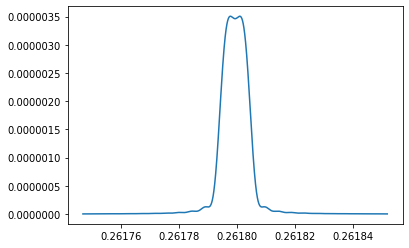

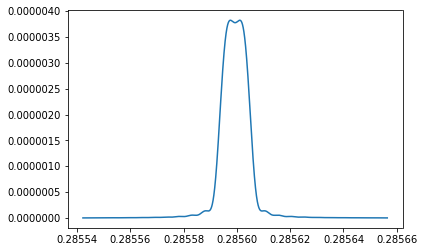

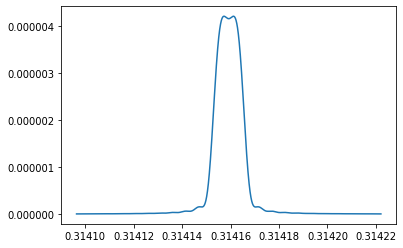

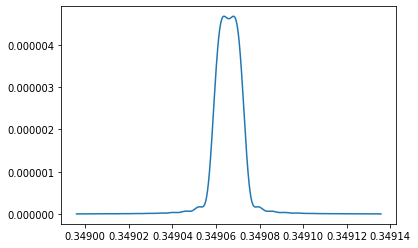

In [2]:
lambda_over_d_central_all = [np.pi/12, np.pi/11, np.pi/10, np.pi/9]
slit_width = 0.00002
for lambda_over_d_central in lambda_over_d_central_all:
    lambda_over_d_all, integral_all = intensity_integral(slit_width, lambda_over_d_central)
    plt.plot(lambda_over_d_all, integral_all)
    plt.show()

In [22]:
theta = np.linspace(-np.pi, np.pi, 1000000)
intensity_list = []
for i in theta: 
    intensity = intensity_density(i, np.pi/6)
    intensity_list.append(intensity)
plt.figure(figsize = (12, 8))
plt.plot(theta, intensity_list)

In [2]:
from calibration.stability import run_test_spectrometer

/Users/mingyu/Desktop/OPMD_acq/OPMD_acq/testbench_funcs.py:97: UserWarning: no Archon connected to server, CCD functionality will be disabled...
  warn("no Archon connected to server, CCD functionality will be disabled...")



Current Time 2020-02-05 14:35:37.018550 Working on trial 0
Getting spectrum and power for wavelength: 600.00

Current Time 2020-02-05 14:35:38.702703 Working on trial 1
Getting spectrum and power for wavelength: 600.00

Current Time 2020-02-05 14:35:40.457344 Working on trial 2
Getting spectrum and power for wavelength: 600.00

Current Time 2020-02-05 14:35:42.081525 Working on trial 3
Getting spectrum and power for wavelength: 600.00

Current Time 2020-02-05 14:35:43.788089 Working on trial 4
Getting spectrum and power for wavelength: 600.00

Current Time 2020-02-05 14:35:45.459361 Working on trial 5
Getting spectrum and power for wavelength: 600.00

Current Time 2020-02-05 14:35:47.305321 Working on trial 6
Getting spectrum and power for wavelength: 600.00

Current Time 2020-02-05 14:35:49.124214 Working on trial 7
Getting spectrum and power for wavelength: 600.00

Current Time 2020-02-05 14:35:50.857720 Working on trial 8
Getting spectrum and power for wavelength: 600.00

Current T


Current Time 2020-02-05 14:37:47.318182 Working on trial 74
Getting spectrum and power for wavelength: 600.00

Current Time 2020-02-05 14:37:49.184801 Working on trial 75
Getting spectrum and power for wavelength: 600.00

Current Time 2020-02-05 14:37:50.800426 Working on trial 76
Getting spectrum and power for wavelength: 600.00

Current Time 2020-02-05 14:37:52.637579 Working on trial 77
Getting spectrum and power for wavelength: 600.00

Current Time 2020-02-05 14:37:54.789706 Working on trial 78
Getting spectrum and power for wavelength: 600.00

Current Time 2020-02-05 14:37:56.837567 Working on trial 79
Getting spectrum and power for wavelength: 600.00

Current Time 2020-02-05 14:37:58.681157 Working on trial 80
Getting spectrum and power for wavelength: 600.00

Current Time 2020-02-05 14:38:00.423851 Working on trial 81
Getting spectrum and power for wavelength: 600.00

Current Time 2020-02-05 14:38:02.160954 Working on trial 82
Getting spectrum and power for wavelength: 600.00




Current Time 2020-02-05 14:40:04.669354 Working on trial 148
Getting spectrum and power for wavelength: 600.00

Current Time 2020-02-05 14:40:06.975758 Working on trial 149
Getting spectrum and power for wavelength: 600.00

Current Time 2020-02-05 14:40:09.316847 Working on trial 150
Getting spectrum and power for wavelength: 600.00

Current Time 2020-02-05 14:40:10.981120 Working on trial 151
Getting spectrum and power for wavelength: 600.00

Current Time 2020-02-05 14:40:12.732303 Working on trial 152
Getting spectrum and power for wavelength: 600.00

Current Time 2020-02-05 14:40:14.564026 Working on trial 153
Getting spectrum and power for wavelength: 600.00

Current Time 2020-02-05 14:40:16.307026 Working on trial 154
Getting spectrum and power for wavelength: 600.00

Current Time 2020-02-05 14:40:17.944091 Working on trial 155
Getting spectrum and power for wavelength: 600.00

Current Time 2020-02-05 14:40:19.783869 Working on trial 156
Getting spectrum and power for wavelength:


Current Time 2020-02-05 14:42:24.304916 Working on trial 222
Getting spectrum and power for wavelength: 600.00

Current Time 2020-02-05 14:42:26.455212 Working on trial 223
Getting spectrum and power for wavelength: 600.00

Current Time 2020-02-05 14:42:28.194702 Working on trial 224
Getting spectrum and power for wavelength: 600.00

Current Time 2020-02-05 14:42:30.038919 Working on trial 225
Getting spectrum and power for wavelength: 600.00

Current Time 2020-02-05 14:42:31.880713 Working on trial 226
Getting spectrum and power for wavelength: 600.00

Current Time 2020-02-05 14:42:33.930963 Working on trial 227
Getting spectrum and power for wavelength: 600.00

Current Time 2020-02-05 14:42:35.812415 Working on trial 228
Getting spectrum and power for wavelength: 600.00

Current Time 2020-02-05 14:42:37.519613 Working on trial 229
Getting spectrum and power for wavelength: 600.00

Current Time 2020-02-05 14:42:39.629981 Working on trial 230
Getting spectrum and power for wavelength:


Current Time 2020-02-05 14:44:39.140354 Working on trial 296
Getting spectrum and power for wavelength: 600.00

Current Time 2020-02-05 14:44:41.211435 Working on trial 297
Getting spectrum and power for wavelength: 600.00

Current Time 2020-02-05 14:44:43.374725 Working on trial 298
Getting spectrum and power for wavelength: 600.00

Current Time 2020-02-05 14:44:45.217845 Working on trial 299
Getting spectrum and power for wavelength: 600.00

Current Time 2020-02-05 14:44:47.160246 Working on trial 300
Getting spectrum and power for wavelength: 600.00

Current Time 2020-02-05 14:44:49.244168 Working on trial 301
Getting spectrum and power for wavelength: 600.00

Current Time 2020-02-05 14:44:50.949763 Working on trial 302
Getting spectrum and power for wavelength: 600.00

Current Time 2020-02-05 14:44:52.606594 Working on trial 303
Getting spectrum and power for wavelength: 600.00

Current Time 2020-02-05 14:44:54.728588 Working on trial 304
Getting spectrum and power for wavelength:


Current Time 2020-02-05 14:47:04.469230 Working on trial 370
Getting spectrum and power for wavelength: 600.00

Current Time 2020-02-05 14:47:06.716811 Working on trial 371
Getting spectrum and power for wavelength: 600.00

Current Time 2020-02-05 14:47:08.511404 Working on trial 372
Getting spectrum and power for wavelength: 600.00

Current Time 2020-02-05 14:47:10.197220 Working on trial 373
Getting spectrum and power for wavelength: 600.00

Current Time 2020-02-05 14:47:12.042895 Working on trial 374
Getting spectrum and power for wavelength: 600.00

Current Time 2020-02-05 14:47:13.894255 Working on trial 375
Getting spectrum and power for wavelength: 600.00

Current Time 2020-02-05 14:47:15.640017 Working on trial 376
Getting spectrum and power for wavelength: 600.00

Current Time 2020-02-05 14:47:18.932812 Working on trial 377
Getting spectrum and power for wavelength: 600.00

Current Time 2020-02-05 14:47:21.369609 Working on trial 378
Getting spectrum and power for wavelength:


Current Time 2020-02-05 14:49:28.746686 Working on trial 444
Getting spectrum and power for wavelength: 600.00

Current Time 2020-02-05 14:49:30.487228 Working on trial 445
Getting spectrum and power for wavelength: 600.00

Current Time 2020-02-05 14:49:32.328842 Working on trial 446
Getting spectrum and power for wavelength: 600.00

Current Time 2020-02-05 14:49:34.170468 Working on trial 447
Getting spectrum and power for wavelength: 600.00

Current Time 2020-02-05 14:49:35.783771 Working on trial 448
Getting spectrum and power for wavelength: 600.00

Current Time 2020-02-05 14:49:37.450342 Working on trial 449
Getting spectrum and power for wavelength: 600.00

Current Time 2020-02-05 14:49:39.188671 Working on trial 450
Getting spectrum and power for wavelength: 600.00

Current Time 2020-02-05 14:49:40.921209 Working on trial 451
Getting spectrum and power for wavelength: 600.00

Current Time 2020-02-05 14:49:42.574914 Working on trial 452
Getting spectrum and power for wavelength:


Current Time 2020-02-05 14:51:38.172706 Working on trial 518
Getting spectrum and power for wavelength: 600.00

Current Time 2020-02-05 14:51:39.977768 Working on trial 519
Getting spectrum and power for wavelength: 600.00

Current Time 2020-02-05 14:51:41.552250 Working on trial 520
Getting spectrum and power for wavelength: 600.00

Current Time 2020-02-05 14:51:43.266777 Working on trial 521
Getting spectrum and power for wavelength: 600.00

Current Time 2020-02-05 14:51:44.931481 Working on trial 522
Getting spectrum and power for wavelength: 600.00

Current Time 2020-02-05 14:51:46.466446 Working on trial 523
Getting spectrum and power for wavelength: 600.00

Current Time 2020-02-05 14:51:48.313782 Working on trial 524
Getting spectrum and power for wavelength: 600.00

Current Time 2020-02-05 14:51:49.781073 Working on trial 525
Getting spectrum and power for wavelength: 600.00

Current Time 2020-02-05 14:51:51.904782 Working on trial 526
Getting spectrum and power for wavelength:


Current Time 2020-02-05 14:53:49.140824 Working on trial 592
Getting spectrum and power for wavelength: 600.00

Current Time 2020-02-05 14:53:50.782026 Working on trial 593
Getting spectrum and power for wavelength: 600.00

Current Time 2020-02-05 14:53:52.521525 Working on trial 594
Getting spectrum and power for wavelength: 600.00

Current Time 2020-02-05 14:53:54.230078 Working on trial 595
Getting spectrum and power for wavelength: 600.00

Current Time 2020-02-05 14:53:56.005669 Working on trial 596
Getting spectrum and power for wavelength: 600.00

Current Time 2020-02-05 14:53:57.747822 Working on trial 597
Getting spectrum and power for wavelength: 600.00

Current Time 2020-02-05 14:53:59.551656 Working on trial 598
Getting spectrum and power for wavelength: 600.00

Current Time 2020-02-05 14:54:01.226000 Working on trial 599
Getting spectrum and power for wavelength: 600.00

Current Time 2020-02-05 14:54:03.068589 Working on trial 600
Getting spectrum and power for wavelength:


Current Time 2020-02-05 14:55:59.493143 Working on trial 666
Getting spectrum and power for wavelength: 600.00

Current Time 2020-02-05 14:56:01.236941 Working on trial 667
Getting spectrum and power for wavelength: 600.00

Current Time 2020-02-05 14:56:02.943744 Working on trial 668
Getting spectrum and power for wavelength: 600.00

Current Time 2020-02-05 14:56:04.587489 Working on trial 669
Getting spectrum and power for wavelength: 600.00

Current Time 2020-02-05 14:56:06.149351 Working on trial 670
Getting spectrum and power for wavelength: 600.00

Current Time 2020-02-05 14:56:07.790226 Working on trial 671
Getting spectrum and power for wavelength: 600.00

Current Time 2020-02-05 14:56:09.632718 Working on trial 672
Getting spectrum and power for wavelength: 600.00

Current Time 2020-02-05 14:56:11.155798 Working on trial 673
Getting spectrum and power for wavelength: 600.00

Current Time 2020-02-05 14:56:13.013279 Working on trial 674
Getting spectrum and power for wavelength:


Current Time 2020-02-05 14:58:06.768183 Working on trial 740
Getting spectrum and power for wavelength: 600.00

Current Time 2020-02-05 14:58:08.271562 Working on trial 741
Getting spectrum and power for wavelength: 600.00

Current Time 2020-02-05 14:58:10.259424 Working on trial 742
Getting spectrum and power for wavelength: 600.00

Current Time 2020-02-05 14:58:12.103264 Working on trial 743
Getting spectrum and power for wavelength: 600.00

Current Time 2020-02-05 14:58:13.844076 Working on trial 744
Getting spectrum and power for wavelength: 600.00

Current Time 2020-02-05 14:58:15.584061 Working on trial 745
Getting spectrum and power for wavelength: 600.00

Current Time 2020-02-05 14:58:17.325389 Working on trial 746
Getting spectrum and power for wavelength: 600.00

Current Time 2020-02-05 14:58:19.237379 Working on trial 747
Getting spectrum and power for wavelength: 600.00

Current Time 2020-02-05 14:58:20.882444 Working on trial 748
Getting spectrum and power for wavelength:


Current Time 2020-02-05 15:00:14.978309 Working on trial 814
Getting spectrum and power for wavelength: 600.00

Current Time 2020-02-05 15:00:16.890945 Working on trial 815
Getting spectrum and power for wavelength: 600.00

Current Time 2020-02-05 15:00:18.769013 Working on trial 816
Getting spectrum and power for wavelength: 600.00

Current Time 2020-02-05 15:00:20.511071 Working on trial 817
Getting spectrum and power for wavelength: 600.00

Current Time 2020-02-05 15:00:22.147646 Working on trial 818
Getting spectrum and power for wavelength: 600.00

Current Time 2020-02-05 15:00:23.989167 Working on trial 819
Getting spectrum and power for wavelength: 600.00

Current Time 2020-02-05 15:00:25.629051 Working on trial 820
Getting spectrum and power for wavelength: 600.00

Current Time 2020-02-05 15:00:27.469449 Working on trial 821
Getting spectrum and power for wavelength: 600.00

Current Time 2020-02-05 15:00:29.224207 Working on trial 822
Getting spectrum and power for wavelength:


Current Time 2020-02-05 15:02:19.495829 Working on trial 888
Getting spectrum and power for wavelength: 600.00

Current Time 2020-02-05 15:02:21.021118 Working on trial 889
Getting spectrum and power for wavelength: 600.00

Current Time 2020-02-05 15:02:22.495477 Working on trial 890
Getting spectrum and power for wavelength: 600.00

Current Time 2020-02-05 15:02:23.973764 Working on trial 891
Getting spectrum and power for wavelength: 600.00

Current Time 2020-02-05 15:02:25.541581 Working on trial 892
Getting spectrum and power for wavelength: 600.00

Current Time 2020-02-05 15:02:27.188323 Working on trial 893
Getting spectrum and power for wavelength: 600.00

Current Time 2020-02-05 15:02:28.818397 Working on trial 894
Getting spectrum and power for wavelength: 600.00

Current Time 2020-02-05 15:02:30.350557 Working on trial 895
Getting spectrum and power for wavelength: 600.00

Current Time 2020-02-05 15:02:32.384019 Working on trial 896
Getting spectrum and power for wavelength:


Current Time 2020-02-05 15:04:24.321483 Working on trial 962
Getting spectrum and power for wavelength: 600.00

Current Time 2020-02-05 15:04:26.164767 Working on trial 963
Getting spectrum and power for wavelength: 600.00

Current Time 2020-02-05 15:04:27.902911 Working on trial 964
Getting spectrum and power for wavelength: 600.00

Current Time 2020-02-05 15:04:29.745542 Working on trial 965
Getting spectrum and power for wavelength: 600.00

Current Time 2020-02-05 15:04:31.793679 Working on trial 966
Getting spectrum and power for wavelength: 600.00

Current Time 2020-02-05 15:04:33.355312 Working on trial 967
Getting spectrum and power for wavelength: 600.00

Current Time 2020-02-05 15:04:34.885053 Working on trial 968
Getting spectrum and power for wavelength: 600.00

Current Time 2020-02-05 15:04:36.356615 Working on trial 969
Getting spectrum and power for wavelength: 600.00

Current Time 2020-02-05 15:04:37.852370 Working on trial 970
Getting spectrum and power for wavelength:

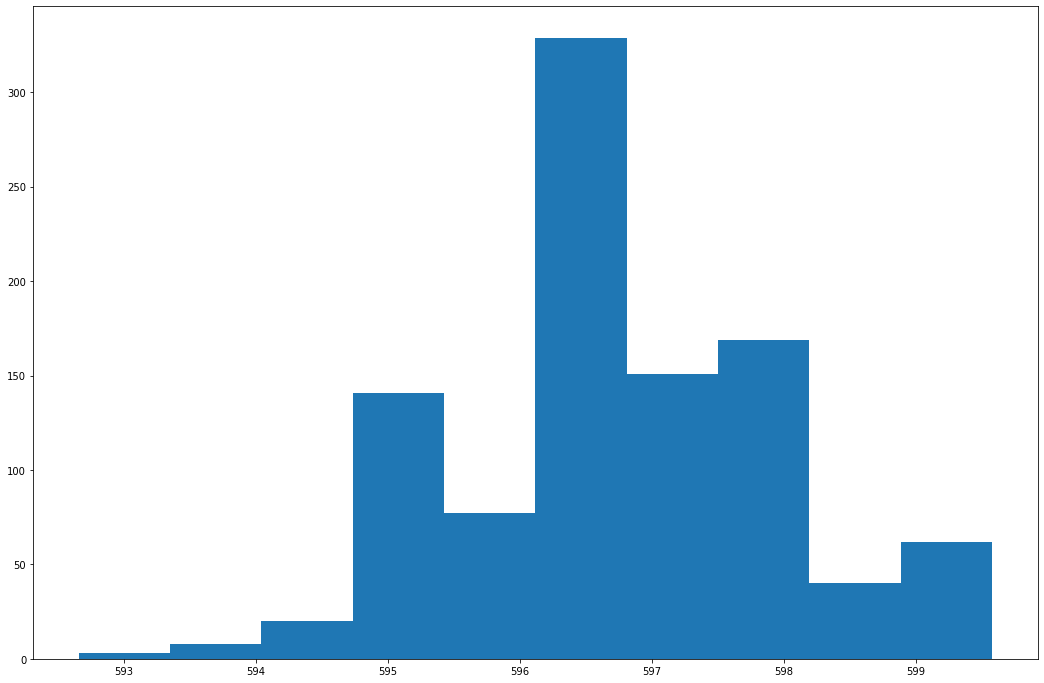

In [4]:
trials = 1000
wls = [600]
exposure = 300
repeat = 1
central_wl_trials, fig = run_test_spectrometer(trials, wls, exposure, repeat)

- The integral doesn't converge -> use a small value in denomenator 
- The linspace is not fine enough 

In [1]:
import matplotlib.pyplot as plt
from experiment.experiment import tb
from scipy.signal import medfilt
import numpy as np
from scipy.signal import butter
from scipy.signal import filtfilt
# wls, spec, spec_s = tb.read_smooth_spectrum(300)
# tb.set_lamp_current(10.0)
# print(tb.get_lamp_current())
wls, spec, base_filter_spec, wls_, spec_ = tb.read_smooth_spectrum(300)


/Users/mingyu/Desktop/OPMD_acq/OPMD_acq/testbench_funcs.py:99: UserWarning: no Archon connected to server, CCD functionality will be disabled...
  warn("no Archon connected to server, CCD functionality will be disabled...")


164.02680455030102


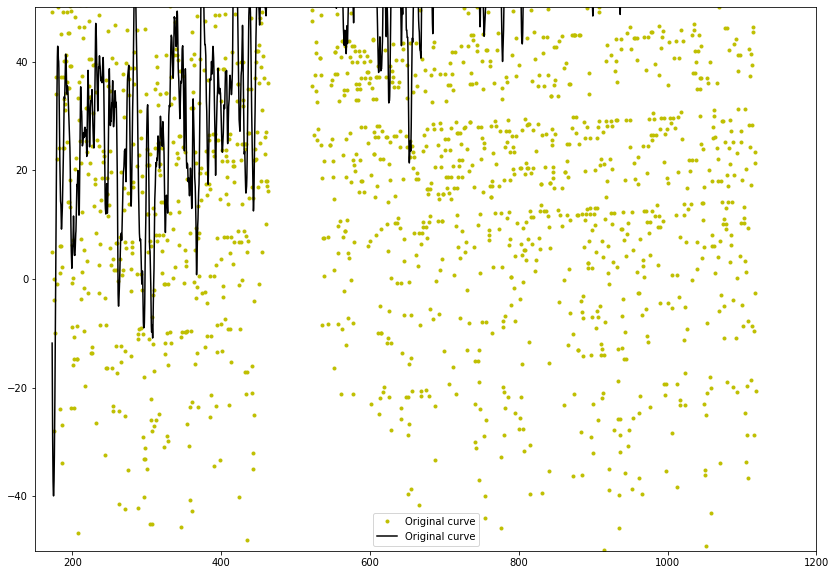

In [4]:
fig = plt.figure(figsize=(14, 10))

plt.plot(wls, spec-baseline, 'y.', label= 'Original curve')
plt.plot(wls_, spec_, 'k-', label= 'Original curve')
plt.legend(loc='best')
# plt.xlim(150, 1200)
# plt.ylim(-50, 50)
plt.legend(loc='best')